In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import re
from matplotlib.text import Annotation
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Configurations

In [4]:
SAVE_FIGURES = False

In [5]:
onet_skills = pd.read_excel('onet_skills.xlsx')

# Unstack
onet_skills_unstacked = onet_skills.loc[onet_skills['Scale Name'] == 'Level', ['O*NET-SOC Code', 'Title', 'Element Name', 'Data Value']] \
    .set_index(['O*NET-SOC Code', 'Title', 'Element Name']).unstack(2)
onet_skills_unstacked.columns = [skill for _, skill in onet_skills_unstacked.columns] # flatten multi-layered columns

In [6]:
# onet_skills_usefullness = onet_skills_unstacked.agg(['min', 'max', 'std'])
# onet_skills_usefullness.loc['range', :] = onet_skills_usefullness.loc['max'] - onet_skills_usefullness.loc['min']
# display(onet_skills_usefullness.loc[['range', 'std']].T.sort_values('std'))

In [7]:
# onet_skills_unstacked.drop(
#     inplace=True, 
#     columns=[
#         'Time Management', 'Coordination', 'Monitoring', 
#         'Critical Thinking', 'Active Listening', 'Judgment and Decision Making'
#     ]
# )

# Finding Ideal Number of Clusters

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.1

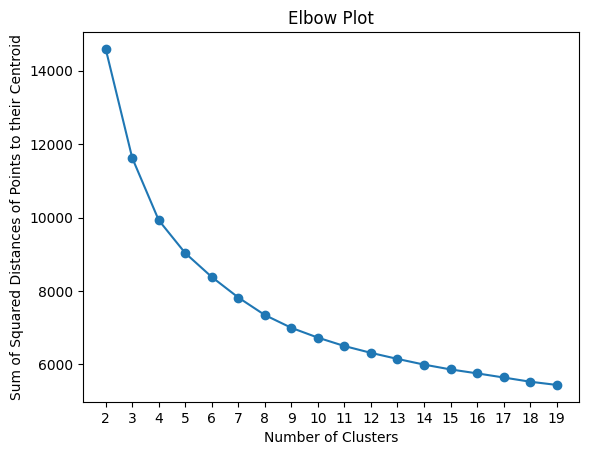

In [8]:
max_num_clusters_trying = 20

losses = []
for num_clusters in range(2, max_num_clusters_trying):
    model = KMeans(
        n_clusters=num_clusters
    ).fit(
        onet_skills_unstacked.values
    )
    losses.append(model.inertia_)

figure = plt.figure()
axes = figure.add_subplot(111)
axes.set_title('Elbow Plot')
axes.set_xlabel('Number of Clusters')
axes.set_xticks(ticks=range(len(losses)), labels=range(2, max_num_clusters_trying))
axes.set_ylabel('Sum of Squared Distances of Points to their Centroid')

axes.plot(losses, marker='o')

My judgement is that around 10 clusters is where the plot seems to plateau.

# Clustering

In [9]:
model = KMeans(n_clusters=15).fit(onet_skills_unstacked.values)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
onet_skills_unstacked['Cluster'] = model.labels_

# Analyzing Clusters

## Assessing Fit

In [12]:
print(f"Silhouette Score: {silhouette_score(onet_skills_unstacked.drop(columns='Cluster'), onet_skills_unstacked['Cluster'])}")
print(f"Calinski Harabasz Score: {calinski_harabasz_score(onet_skills_unstacked.drop(columns='Cluster'), onet_skills_unstacked['Cluster'])}")

Silhouette Score: 0.1555675219707888
Calinski Harabasz Score: 176.18849013432984


## Visualizing with Decision Trees

Idea of visualizing cluster models with decision trees taken from <url>https://docs.interpretable.ai/stable/examples/clustering/</url>

In [13]:
decision_tree = DecisionTreeClassifier().fit(
    X=onet_skills_unstacked.drop(columns='Cluster').values, 
    y=onet_skills_unstacked['Cluster'].values,
)

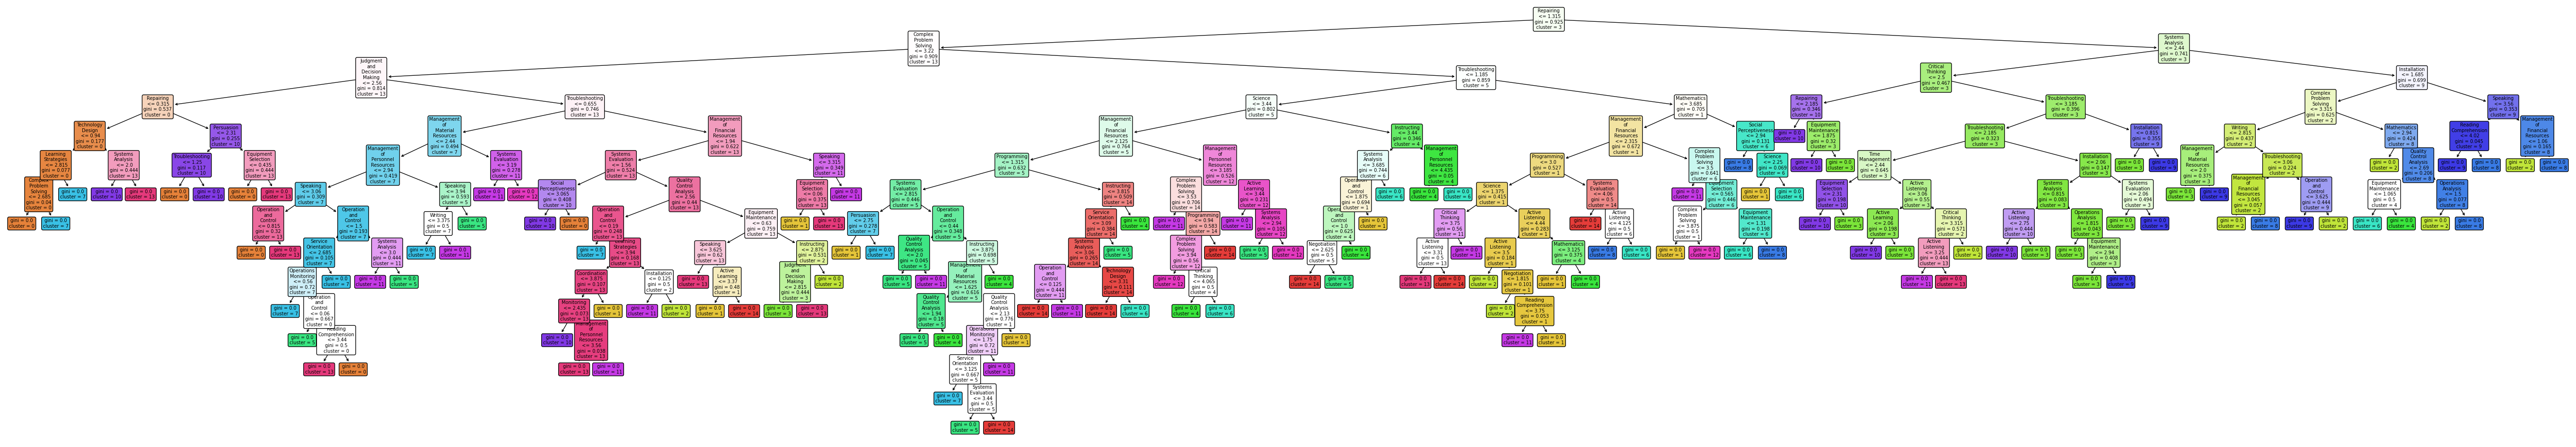

In [25]:
figure = plt.figure(figsize=(70, 12));
axes = figure.add_subplot(111);

plot_tree(
    decision_tree, 
    feature_names=onet_skills_unstacked.drop(columns='Cluster').columns,
    impurity=True,
    fontsize=7, 
    rounded=True, 
    filled=True, 
    ax=axes
);

for property in axes.properties()['children']:
    # for every axes property that is a `Text` object,
    if type(property) == Annotation:
        
        text_content = property.get_text()

        #--------------------------------------------------------------------#
        # Breaking up long skill names into multiple lines
        #--------------------------------------------------------------------#
        skill_name_position = re.search(pattern="[><]", string=text_content)
        if skill_name_position:
            skill_name_end_index = skill_name_position.start() - 1
            skill_name = text_content[:skill_name_end_index + 1].replace(' ', '\n')
            text_content = skill_name + text_content[skill_name_end_index:]

        #--------------------------------------------------------------------#
        # Delete "samples" detail in each node (e.g. samples = 32)
        #--------------------------------------------------------------------#
        sample_detail = re.search(
            pattern="(samples = )[^(\\n)]*(\\n)",
            string=text_content
        )
        text_content = text_content[0:sample_detail.start()] + text_content[sample_detail.end():]

        #--------------------------------------------------------------------#
        # Replace array of cluster assignments with the mode cluster
        # and rename from "value" to "cluster"
        #--------------------------------------------------------------------#
        # find the index in text where the cluster assignments array is displayed
        values_start_index = re.search(
            pattern="(value = \[)[^\]]*(\])", 
            string=text_content
        ).start()
        # calculate the most popular cluster in this node's subsample
        most_popular_class = np.array(
            re.split(
                pattern=', |\\n',
                string = text_content[values_start_index + 8:][1:-1]
            )
        ).astype('float').argmax()
        # in the text, replace the values array with just the most popular cluster
        property.set_text(
            text_content[:values_start_index] + 'cluster = ' + str(most_popular_class)
        )

## Descriptive Statistics of the Clusters

In [26]:
if SAVE_FIGURES:
    excel_writer = pd.ExcelWriter('optimalKMeansClustering.xlsx')

In [29]:
centroids = pd.DataFrame(
    columns = onet_skills_unstacked.drop(columns='Cluster').columns, 
    index = pd.Series(range(model.n_clusters), name='Cluster'), 
    data=model.cluster_centers_
)
if SAVE_FIGURES:
    centroids.to_excel(excel_writer, 'Cluster Centers')
display(centroids.style)

,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,Learning Strategies,Management of Financial Resources,Management of Material Resources,Management of Personnel Resources,Mathematics,Monitoring,Negotiation,Operation and Control,Operations Analysis,Operations Monitoring,Persuasion,Programming,Quality Control Analysis,Reading Comprehension,Repairing,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.153818,2.908909,2.157818,2.599273,2.706545,0.168000,0.185636,0.008909,1.874545,2.217455,1.819636,0.533818,0.653273,1.719818,1.495636,2.579091,1.903091,0.949818,0.436182,1.396000,2.088000,0.213455,1.272545,2.702182,0.077455,0.120182,2.601455,2.643091,2.734000,1.361818,1.272727,0.306364,2.324545,0.704909,2.413273
1,3.657600,3.999000,3.644000,3.397400,4.043000,0.357000,0.733800,0.140200,3.325600,3.700400,3.235600,1.372000,1.631200,2.883200,2.918000,3.825200,2.850000,2.408200,2.302000,2.888800,3.043000,0.977000,2.742400,4.243400,0.279000,2.936000,3.258400,3.459400,3.932000,3.169800,3.175800,1.248200,3.247800,1.799200,3.764800
2,3.186607,3.605179,3.125357,3.236607,3.644643,2.120000,1.980179,0.229464,3.049107,3.152500,3.018929,1.211250,1.639643,2.823571,2.778393,3.526964,2.534464,2.889286,1.523750,3.140179,2.689464,0.812679,2.922857,3.710893,1.958571,2.132679,2.873571,3.112500,3.478571,2.805357,2.755000,1.028214,3.133571,2.426786,3.270000
3,2.434286,2.863175,2.636825,2.766429,2.944603,2.597222,2.157381,0.641587,2.340159,2.645556,2.172063,0.835794,1.132460,2.114206,2.058016,2.957778,1.905635,3.132143,1.059048,3.215556,2.049683,0.299841,2.919444,2.794444,2.557857,0.687857,2.154048,2.404206,2.683730,1.960635,1.927857,0.775079,2.667619,2.688810,2.403413
4,4.295926,4.348519,4.018333,3.461111,4.376481,0.089815,0.321667,0.011481,4.086111,4.067778,3.912778,1.472037,1.597037,3.030185,3.405000,3.976667,2.879630,0.624259,2.671667,1.574259,3.221852,1.140556,1.604259,4.925926,0.085926,3.885741,3.404444,3.825926,4.442778,3.353148,3.408889,0.965556,3.476481,0.578148,4.510000
5,3.950312,4.309531,3.622813,3.425937,4.152188,0.000000,0.091562,0.003906,3.671406,3.792969,3.806875,0.968906,1.134688,2.875938,2.370312,3.895000,3.158281,0.263438,1.925938,0.955156,3.388125,0.709531,0.783281,4.451250,0.007813,1.701719,3.408437,4.087500,4.353594,3.133906,3.195469,0.794844,3.371250,0.162031,4.287344
6,4.243636,4.141364,4.182727,3.571364,4.349773,0.274091,1.048864,0.078182,3.450682,4.140227,3.454773,2.487500,2.495909,3.262955,4.023636,3.975455,3.065000,1.690909,3.443636,2.744318,3.284318,1.961136,2.913636,4.730682,0.271136,3.863864,3.001818,3.325455,4.124091,3.815909,3.837727,2.441818,3.574773,1.856818,4.280227
7,3.141538,3.789231,2.952923,3.012000,3.625692,0.022923,0.056462,0.005692,2.660462,3.085846,2.703538,0.905077,0.823231,2.267692,2.202154,3.151231,2.785846,0.263692,1.023538,0.903846,2.904769,0.646615,0.772000,3.785385,0.009385,0.270769,3.135231,3.201692,3.681538,2.356923,2.296308,0.603077,3.004923,0.180462,3.496615
8,3.924615,3.932308,3.884359,3.388974,4.084359,2.280513,2.546667,0.848205,3.401282,3.805385,3.282308,2.260256,2.448462,3.149487,3.784872,3.888974,2.883590,2.556154,2.975897,3.281538,3.128462,2.157436,3.395641,4.321026,2.247949,3.069231,2.907692,3.254615,3.922051,3.571282,3.582564,2.330769,3.360000,2.877436,3.913590


In [30]:
centroids_standardized = centroids.copy()
for skill in centroids_standardized.columns:
    centroids_standardized[skill] = \
        (centroids[skill] - centroids[skill].mean()) / centroids[skill].std()

centroids_standardized_display = centroids_standardized.style.apply(
    lambda col:
        [
            "background-color:mediumseagreen;" if z == col.max() 
            else "background-color:lightgreen;" if z > 0.75
            else None 
            for z in col 
        ],
    axis=0
)

if SAVE_FIGURES:
    centroids_standardized_display.to_excel(excel_writer, 'Centroids Standardized')
display(centroids_standardized_display)

,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,Learning Strategies,Management of Financial Resources,Management of Material Resources,Management of Personnel Resources,Mathematics,Monitoring,Negotiation,Operation and Control,Operations Analysis,Operations Monitoring,Persuasion,Programming,Quality Control Analysis,Reading Comprehension,Repairing,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.635413,-1.335916,-1.764577,-1.624859,-1.694130,-0.635752,-0.846624,-0.494503,-1.814518,-1.757874,-1.737306,-1.193330,-1.378151,-1.690080,-1.577765,-1.751125,-1.397363,-0.618768,-1.585802,-0.936073,-1.374460,-1.082420,-1.007415,-1.430275,-0.681459,-1.176221,-0.760844,-1.040023,-1.338298,-1.851575,-1.851208,-1.289345,-1.852720,-0.717405,-1.370976
1,0.449634,0.615059,0.563162,0.489064,0.615250,-0.469046,-0.265118,-0.287769,0.489811,0.600764,0.425463,-0.161325,0.031267,0.328305,0.248285,0.712216,0.339192,0.735184,0.454033,0.784627,0.297680,-0.004531,0.689558,0.596665,-0.505337,0.992578,0.749384,0.494696,0.537139,0.470670,0.453564,0.234293,0.298764,0.317524,0.418067
2,-0.203414,-0.089777,-0.249165,0.063187,-0.073107,1.085993,1.057072,-0.147212,0.050730,-0.270676,0.094515,-0.359247,0.043436,0.224854,0.069056,0.122655,-0.239475,1.181821,-0.396801,1.074382,-0.321337,-0.236502,0.897899,-0.103664,0.962369,0.373844,-0.135284,-0.157501,-0.172691,0.002565,-0.056058,-0.121584,0.032574,0.911065,-0.236910
3,-1.246535,-1.417769,-1.014330,-1.182129,-1.282769,1.506923,1.245052,0.501726,-1.075107,-1.076975,-1.199002,-0.821525,-0.687532,-1.005845,-0.855775,-1.002527,-1.392698,1.407288,-0.904844,1.161267,-1.441551,-0.960469,0.893959,-1.308936,1.486059,-0.738986,-1.789371,-1.489142,-1.416994,-1.082430,-1.057794,-0.531089,-1.053247,1.158874,-1.384028
4,1.334696,1.240605,1.149464,0.657809,1.191503,-0.704714,-0.702320,-0.490452,1.697532,1.185081,1.459797,-0.038155,-0.017969,0.583314,0.873503,1.011639,0.393531,-0.921015,0.858176,-0.730599,0.610837,0.226359,-0.624446,1.494292,-0.674056,1.724086,1.085120,1.183790,1.336748,0.706170,0.735853,-0.222949,0.831667,-0.837289,1.404502
5,0.855491,1.170828,0.529977,0.564648,0.803925,-0.783935,-0.946420,-0.502380,1.038965,0.747995,1.298039,-0.657631,-0.684322,0.315705,-0.454844,0.850198,0.904556,-1.255999,0.042896,-1.444218,0.901970,-0.382114,-1.572279,0.870019,-0.742316,0.041910,1.094299,1.675567,1.197133,0.424567,0.477384,-0.499115,0.586443,-1.230833,1.109768
6,1.262195,0.869852,1.406947,0.949824,1.145350,-0.542175,0.069109,-0.385424,0.688446,1.300313,0.760232,1.212126,1.277513,0.987153,1.667717,1.009243,0.733485,0.069256,1.702144,0.618087,0.720212,1.384764,0.887253,1.237515,-0.512209,1.707236,0.159537,0.242869,0.837852,1.300559,1.255210,2.165247,1.060718,0.372016,1.100348
7,-0.265904,0.239627,-0.519240,-0.531708,-0.105854,-0.763716,-0.983656,-0.499568,-0.566454,-0.376689,-0.387217,-0.736220,-1.133203,-0.739557,-0.670728,-0.620104,0.221539,-1.255762,-0.943665,-1.503362,0.055647,-0.470932,-1.585304,-0.005696,-0.740943,-1.060235,0.466235,0.010187,0.145048,-0.573422,-0.611571,-0.809342,-0.267218,-1.213402,0.063065
8,0.819861,0.495697,0.939626,0.466748,0.686718,1.227572,1.658017,0.827071,0.609997,0.767743,0.496805,0.932334,1.209130,0.790295,1.361187,0.838286,0.400793,0.872544,1.190781,1.237323,0.447317,1.661879,1.443736,0.698754,1.215243,1.095194,-0.056845,0.109686,0.521565,0.986350,0.946187,1.985600,0.560227,1.337268,0.615022


In [31]:
cluster_assignments_display = onet_skills_unstacked['Cluster'] \
    .sort_values() \
    .reset_index() \
    .set_index('Cluster')[['Title', 'O*NET-SOC Code']] \
    .style

if SAVE_FIGURES:
    cluster_assignments_display.to_excel(excel_writer, sheet_name='Cluster Assignments')
display(cluster_assignments_display)

,Title,O*NET-SOC Code
Cluster,,
0,Proofreaders and Copy Markers,43-9081.00
0,Tour Guides and Escorts,39-7011.00
0,Orderlies,31-1132.00
0,Cashiers,41-2011.00
0,Nursing Assistants,31-1131.00
0,Models,41-9012.00
0,Telemarketers,41-9041.00
0,"Switchboard Operators, Including Answering Service",43-2011.00
0,Telephone Operators,43-2021.00


In [32]:
if SAVE_FIGURES:
    excel_writer.close()